# Load Data

In [1]:
 import tensorflow_datasets as tfds
 dataset, info = tfds.load("tf_flowers", as_supervised=True, with_info=True)
 dataset_size = info.splits["train"].num_examples
 class_names = info.features["label"].names
 n_classes = info.features["label"].num_classes

In [2]:
class_names

['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses']

# Data Splitting

In [3]:
 samples,test, valid, train = tfds.load("tf_flowers", split=["train[:1%]","train[2:12%]", "train[12%:27%]", "train[27%:]"], as_supervised=True)

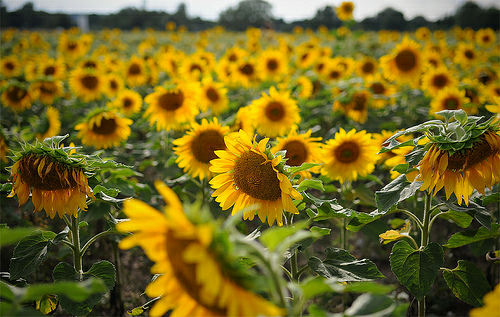

In [4]:
import cv2 as cv
from google.colab.patches import cv2_imshow
import tensorflow as tf
import numpy as np

samples_list = list(samples)
image_np = samples_list[4][0].numpy()  # Convert to NumPy array

# Convert from BGR to RGB
image_rgb = cv.cvtColor(image_np, cv.COLOR_BGR2RGB)

# Display the RGB image
cv2_imshow(image_rgb)

# Data Prepration

In [5]:
import tensorflow as tf

# Set the batch size for training
batch_size = 32

# Define the preprocessing pipeline
preprocess = tf.keras.Sequential([
    tf.keras.layers.Resizing(height=224, width=224, crop_to_aspect_ratio=True),
    tf.keras.layers.Lambda(tf.keras.applications.xception.preprocess_input)
])

# Prepare the training dataset
train_set = train.map(lambda X, y: (preprocess(X), y))  # Apply preprocessing
train_set = train_set.shuffle(1000, seed=42).batch(batch_size).prefetch(1)  # Shuffle, batch, and prefetch

# Prepare the validation dataset
valid_set = valid.map(lambda X, y: (preprocess(X), y)).batch(batch_size)  # Apply preprocessing and batch

# Prepare the test dataset
test_set = test.map(lambda X, y: (preprocess(X), y)).batch(batch_size)  # Apply preprocessing and batch


# Build and Test Model

In [8]:
# # Define the data augmentation model using the functional API
# inputs = tf.keras.Input(shape=(224, 224, 3))  # Input layer
# x = tf.keras.layers.RandomFlip(mode="horizontal", seed=42)(inputs)  # Randomly flip images horizontally
# x = tf.keras.layers.RandomRotation(factor=0.05, seed=42)(x)           # Randomly rotate images
# x = tf.keras.layers.RandomContrast(factor=0.2, seed=42)(x)             # Randomly adjust contrast

# # Add the base model (Xception) without the top layers
# # Store the Xception model in a variable called 'base_xception_model'
# base_xception_model = tf.keras.applications.Xception(include_top=False, weights='imagenet')
# x = base_xception_model(x)  # Pass the augmented input to the base model

# x = tf.keras.layers.GlobalAveragePooling2D()(x)  # Global average pooling layer
# outputs = tf.keras.layers.Dense(5, activation='softmax')(x)  # Final classification layer

# # Create the model
# model = tf.keras.Model(inputs=inputs, outputs=outputs)

# # Now, you can access the layers of the Xception model using 'base_xception_model'
# for layer in base_xception_model.layers[56:]:
#     layer.trainable = True
# # model.summary()

In [6]:
base_model = tf.keras.applications.xception.Xception(weights="imagenet",include_top=False)
avg = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
output = tf.keras.layers.Dense(n_classes, activation="softmax")(avg)
model = tf.keras.Model(inputs=base_model.input, outputs=output)

for layer in base_model.layers[56:]:
 layer.trainable = True
# model.summary()

In [7]:
from tensorflow.keras.callbacks import EarlyStopping

# Initialize early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',     # Metric to monitor
    patience=0,             # Number of epochs with no improvement after which to stop
    restore_best_weights=True  # Restore the best model weights after stopping
)

In [8]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,metrics=["accuracy"])
history = model.fit(train_set, validation_data=valid_set, epochs=10, callbacks=[early_stopping])

Epoch 1/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 124s 878ms/step - accuracy: 0.6474 - loss: 0.9265 - val_accuracy: 0.8566 - val_loss: 0.3629
Epoch 2/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 69s 442ms/step - accuracy: 0.9529 - loss: 0.1496 - val_accuracy: 0.9310 - val_loss: 0.1812
Epoch 3/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 38s 447ms/step - accuracy: 0.9888 - loss: 0.0479 - val_accuracy: 0.9401 - val_loss: 0.1877


In [9]:
from sklearn.metrics import classification_report
import numpy as np

# Generate predictions on the test set
predictions = model.predict(test_set)

# Get the true labels from the test set
true_labels = np.concatenate([y for _, y in test_set], axis=0)

# If predictions are probabilities, convert them to class labels (assuming a multi-class classification)
predicted_labels = np.argmax(predictions, axis=1)

# Apply classification report
report = classification_report(true_labels, predicted_labels)
print(report)


12/12 ━━━━━━━━━━━━━━━━━━━━ 11s 670ms/step
              precision    recall  f1-score   support

           0       0.98      0.95      0.97       107
           1       0.98      0.94      0.96        54
           2       0.81      0.91      0.86        69
           3       1.00      0.97      0.98        60
           4       0.89      0.87      0.88        77

    accuracy                           0.93       367
   macro avg       0.93      0.93      0.93       367
weighted avg       0.93      0.93      0.93       367



# Deployment

In [12]:
# Save model weights with the correct extension
model.save_weights("model.weights.h5")

# **THANKS**